# Normalization Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')

## Load Data

In [2]:
# Define user for path setting
dataset_path = '/Users/zfphil/datasets/motiondeblur/'

# Define which dataset to use
dataset_type = 'coded'
dataset_label =  '171a'

# Find files in this directory
folder_list = glob.glob(os.path.join(dataset_path, '*/'))
dataset_list = [folder for folder in folder_list if isDataset(folder)]

# Filter datasets in directory
filtered_dataset_list = [folder_name for folder_name in folder_list if (dataset_type in folder_name) and (dataset_label in folder_name)]
assert not len(filtered_dataset_list) > 1, "More than one dataset with criterion found!"
assert not len(filtered_dataset_list) == 0, "No dataset with criterion found!"

# Create dataset object (loads metadata)
dataset = Dataset(filtered_dataset_list[0])

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

# Select green channel
dataset.channel_mask = [0]

# Preprocess dataset (md-specific)
md.preprocess(dataset)

Loading 1 frames...


# Create Recon Object

In [32]:
# Clear frames (so any normalizations are overwritten)
dataset.clearFramesFromMemory()

# Set position segment
dataset.position_segment_indicies = [10]

# Create recon object
recon = md.recon.Reconstruction(dataset)

# Apply frame-dependent position offset
recon.applyFrameDependentOffset(offset=26)

Loading 30 frames...


## Save Un-normalized Strip

In [7]:
recon.reconstruct(mode='static', iteration_count=-1)

recon.reg_types_recon = None
recon.save('/Users/zfphil/Desktop/', filename=recon.dataset.metadata.file_header +  '_norm_none', formats=['png'], save_raw=False, downsample=4)

/Users/zfphil/.conda/lib/python3.7/site-packages/scikit_image-0.14.1-py3.7-macosx-10.7-x86_64.egg/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/zfphil/.conda/lib/python3.7/site-packages/scikit_image-0.14.1-py3.7-macosx-10.7-x86_64.egg/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Perform Un-wrapped Normalization

In [8]:
recon.normalize_measurements(wrap_final_value=False)

recon.reconstruct(mode='static', iteration_count=-1)

recon.reg_types_recon = None
recon.save('/Users/zfphil/Desktop/', filename=recon.dataset.metadata.file_header +  '_norm_unwrapped', formats=['png'], save_raw=False, downsample=4)

In [33]:
recon.normalize_measurements(wrap_final_value=True)

recon.reconstruct(mode='static', iteration_count=-1)

recon.reg_types_recon = None
recon.save('/Users/zfphil/Desktop/', filename=recon.dataset.metadata.file_header +  '_norm_gamma', formats=['png'], save_raw=False, downsample=4)

Calculated wrapping coefficient 0.0782075


## Get Field Flatness Metric 
This is the ratio of the right side to the left side, >1 means the right side is brighter than the left.
Note that this is HIGHLY sample-dependent.

In [ ]:
print(recon.field_flatness_metric(axis=1))
print(recon.field_flatness_metric(axis=0))

## Apply Normalization Without Wrapping

In [ ]:
scale = recon.normalize_measurements(write_results=False, wrap_final_value=False)
plt.figure()
plt.plot(scale)
plt.xlabel('Frame Number')
plt.ylabel('Global Weight Applied to Frame')
plt.title('Weights Applied to each frame')

## Apply Normalization (With Wrapping)

In [ ]:
scale = recon.normalize_measurements(write_results=False, wrap_final_value=True)
plt.figure()
plt.plot(scale)
plt.xlabel('Frame Number')
plt.ylabel('Global Weight Applied to Frame')
plt.title('Weights Applied to each frame')

## Apply Normalization (With high-pass filter)

In [ ]:
scale = recon.normalize_measurements(write_results=False, high_pass_filter=True)
plt.figure()
plt.plot(scale)
plt.xlabel('Frame Number')
plt.ylabel('Global Weight Applied to Frame')
plt.title('Weights Applied to each frame')

## Test Stitching

In [ ]:
recon._gen_measurements(estimated_background=bg_ramp)
# recon.y_list = [y / yp.mean(y) for y in recon.y_list]
scale = recon.normalize_measurements(write_results=True, high_pass_filter=False, wrap_final_value=False, reverse=False)
recon.reconstruct(mode='static', iteration_count=-1)
recon.show()

## Example Normalization Problem
This example generates frames with different values, scaled by a random group of weights and tries to recover the correct normalization. 

Field Flatness is the primary source of error. When field flatness is accounted for, we can perfectly normalize the segment.

A possible way to regularize without knowing field flatness is to enforce the prior that the outer edges of the images are the same by spreading the radio of differences across all frames. This reduces the error but is a bit heuristic.

Potential solutions:
- Estimate field flatness using first frame
- Apply normalization anyway
- Estimate field flatness using all frames
- trust final value and normalize everything so that the first and last normalization is 1.0
What I'm seeing is that the wrap_final_value works well when the edges of the reconstruction are assumed to have the same mean.
However, it introduces signifi

<IPython.core.display.Javascript object>


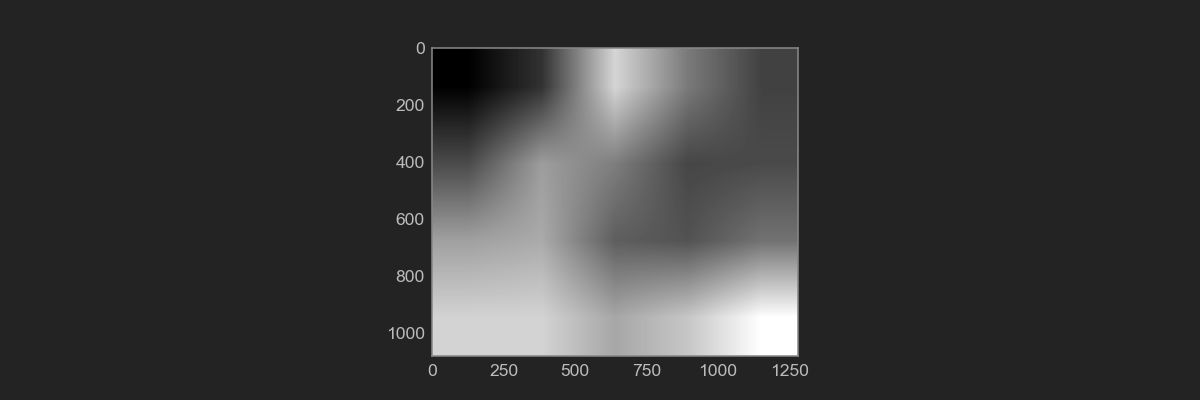

In [119]:
bg = dataset.estimateBackground(batch_size=None)
plt.figure()
plt.imshow(yp.real(bg))

In [ ]:
def estimateBackground(frame_list, downsample_factor=128):
    """Estimate the background of a frame list."""
    import llops as yp

    # Check decimation factor to ensure it is usable
    assert all([sz // downsample_factor > 1 for sz in yp.shape(frame_list[0])])

    # Downsample frames
    frames_downsampled = [yp.vec(yp.filter.downsample(frame, downsample_factor)) for frame in frame_list]

    # Mean-center
    frames_downsampled = [frame - yp.mean(frame) for frame in frames_downsampled]

    # Generate array and take SVD
    A = yp.transpose(yp.asarray(frames_downsampled))
    U, S, V = yp.linalg.svd(A)

    # Upsample first singular vector to get flat-field estimate
    new_shape = [sz // downsample_factor for sz in yp.shape(frame_list[0])]
    recovered_flat_field = yp.filter.upsample(yp.reshape(U[:, 0], new_shape), downsample_factor)

    # Return flat-field
    return recovered_flat_field

plt.figure()
plt.imshow(yp.real(estimateBackground(dataset.frame_list, downsample_factor=32)))

In [ ]:
import scipy as sp
scales_filt = sp.ndimage.filters.gaussian_filter1d(scales, 10)

plt.figure()
plt.subplot(141)
plt.plot(yp.real(scales))
plt.subplot(142)
plt.plot(yp.real(scales_filt))
plt.subplot(143)
plt.plot(yp.real(scales / scales_filt))
plt.subplot(144)
plt.plot(yp.real(scales - scales_filt))

In [ ]:
import libwallerlab.utilities.simulation as sim
import scipy as sp
frame_size = (100, 100)
overlap = 20
sample_len = 100
axis = 1

# These are the measurement weights, which we want to recover
weights = 1.0 + (yp.rand(sample_len)  - 0.5)  * 0.5
weights[0] = 1.0

# Generate ROI list
rois = [yp.Roi(start=(0, index * (frame_size[1] - overlap)), shape=frame_size) for index in range(sample_len)]
for roi in rois:
    roi.input_shape = sum(rois).shape
    
object_size = roi.input_shape

# Generate object
object_true = sim.brain([sz * 2 for sz in object_size], absorption_max=1, absorption_min=0)
object_true = object_true[:object_size[0], :object_size[1]]

# Generate field flatness
field_flatness = yp.ramp(frame_size, axis=1, min_value=1.0, max_value = 1.0)
# field_flatness = yp.ones_like(field_flatness)

# Generate unweighted frames (GROUND TRUTH)
frames_unweighted = [object_true[roi.slice] for roi in rois]

# Generate weighted frames (MEASUREMENT)
frames = [field_flatness * frame * weight for (frame, weight) in zip (frames_unweighted, weights)] 

# Estimate background
background_estimated = md.recon.estimateBackground(frames, downsample_factor=32, pca_threshold_count=2)

# Recover scales
scales, _ = md.recon.normalize_roi_list(frames, rois, wrap_final_value=False, reverse=True)

# Apply high-pass filter to scales
scales_filtered = scales / sp.ndimage.filters.gaussian_filter1d(scales, 5)

# Recover scales (Normalized)
scales_normalized, _ = md.recon.normalize_roi_list(frames - background_estimated, rois, wrap_final_value=False, reverse=True)

# Calculate reweighted frames
new_weights = [1 / scale for scale in scales]
new_weights_normalized = [1 / scale for scale in scales_normalized]
new_weights_filtered= [1 / scale for scale in scales_filtered]

plt.figure()
plt.subplot(121)
plt.plot(weights, label='original weights')
plt.plot(new_weights, label='recovered weights')
plt.plot(new_weights_normalized, label='recovered weights (normalized)')
plt.plot(new_weights_filtered, label='recovered weights (filtered)')
plt.legend()

plt.subplot(122)
plt.plot([yp.mean(frame_unweighted) for frame_unweighted in frames_unweighted], label='ground-truth means')
plt.plot([yp.mean(frame) * 1 / weight for (frame, weight) in zip(frames, new_weights)], label='recovered means')
plt.plot([yp.mean(frame) * 1 / weight for (frame, weight) in zip(frames, new_weights_normalized)], label='recovered means (normalized)')
plt.plot([yp.mean(frame) * 1 / weight for (frame, weight) in zip(frames, new_weights_filtered)], label='recovered means (filtered)')
plt.ylim([0,2])
plt.legend()